# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


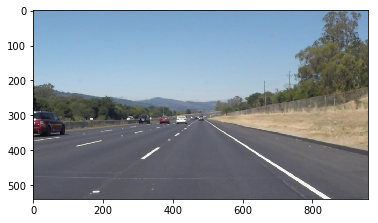

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [171]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    right_slope = []
    left_slope = []

    left_lines = []
    right_lines = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            m = ((y2-y1)/(x2-x1)) # slope
            if (m > 0.15 and m < (0.15*img.shape[1])):
                left_slope.append(m)
                left_lines.append((x2,y2))
            else:
                right_slope.append(m)
                right_lines.append((x1,y1))
    right_slope = np.average(right_slope) #sorted(right_slope)[int(len(right_slope)/2)]
    
    left_slope = np.average(left_slope) #sorted(left_slope)[int(len(left_slope)/2)]

    left_y1 = min([line[1] for line in left_lines])
    left_pair = tuple([line[0] for line in left_lines if line[1] == left_y1] + [left_y1])
    if(len(right_lines)>0):
        right_y1 = min([line[1] for line in right_lines])
    else:
        right_y1 = 0
    right_pair = tuple([line[0] for line in right_lines if line[1] == right_y1] + [right_y1])
    #print("Right: points =  {}, slope = {}, int = {}".format(right_pair, right_slope, int(right_slope)/2))
    left_x = int((img.shape[1]-left_pair[1])/left_slope) + left_pair[0]
#     print("image shape = {}, right pair = {}, right slope = {}".\
#           format(img.shape[1], right_pair, right_slope))
    if(right_slope > 0):
        right_x = int((img.shape[1]-right_pair[1])/right_slope) + right_pair[0]
    else:
        right_x = 0
    
#     print(" Left: {} - {} - {}".format(left_pair, left_x, img.shape[1]))
#     print("Right: {} - {} - {}".format(right_pair, right_x, img.shape[1]))
    if(len(left_pair)==2):
        cv2.line(img, left_pair, (left_x, img.shape[1]), color, thickness+8)
    if(len(right_pair)==2):
        cv2.line(img, right_pair, (right_x, img.shape[1]), color, thickness+8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
images = os.listdir("test_images")
images

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [5]:
os.getcwd()

'/Users/sarvagyagupta1/Desktop/College/SJSU/Spring_2017/udacity/1/CarND-LaneLines-P1-master'

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [160]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
#image1 = mpimg.imread('/Users/sarvagyagupta1/Desktop/College/SJSU/Spring_2017/udacity/1/CarND-LaneLines-P1-master/test_images/solidWhiteCurve.jpg')
def pipeline(image):
    gray = grayscale(image)

    ###########   GAUSS_BLUR   #########
    kernel_size = 5
    blur_img = gaussian_blur(gray, kernel_size)

    ############   CANNY   ###########
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_img,low_threshold,high_threshold)

    ###########   GETTING THE REGION ######
    bottom_left = (0,edges.shape[0])
    top_left = (int((edges.shape[1]/2)-10), int((image.shape[0]/2)+50))
    top_right = (int((edges.shape[1]/2)+10), int((image.shape[0]/2)+50))
    bottom_right = (edges.shape[1],edges.shape[0])
    #vertices = np.array([[(0,edges.shape[0]),((edges.shape[0]/2)-10,(image1.shape[1]/2)+10),\
     #               ((image1.shape[0]/2)+10,(image1.shape[1]/2)+10),(image1.shape[0],(image1.shape[1]))]], dtype=np.int32)
    #vertices = np.array([[(0,edges.shape[0]),(450,290),(490,290),(960,540)]],dtype=np.int32)
    vertices = np.array([[(bottom_left),(top_left),(top_right),(bottom_right)]],dtype=np.int32)
    masked_img = region_of_interest(edges, vertices)

    ############   HOUGH LINES   #########
    rho = 2
    theta = np.pi/180 
    threshold = 10 
    min_line_len = 40 
    max_line_gap = 20
    line_img = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)
    result_img = weighted_img(line_img, image, α=0.8, β=1., λ=0.)
    return result_img



In [26]:
'''class FrameData:
    def __init__(self):
        self.left_lane_points = []
        self.right_lane_points = []
        self.left_lane_m = 0
        self.left_lane_c = 0
        self.right_lane_m = 0
        self.right_lane_c = 0

class Canny:
    def __init__(self, low_threshold, high_threshold):
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold

class Hough:
    def __init__(self, rho, theta, threshold, min_line_length, max_line_gap):
        self.rho = rho
        self.theta = theta
        self.threshold = threshold
        self.min_line_length = min_line_length
        self.max_line_gap = max_line_gap

class Data:
    def __init__(self, canny_low_threshold, canny_high_threshold, rho, theta, threshold, min_line_length, max_line_gap):
        self.roi_vertices = None
        self.prev_frames_data = FrameData()
        self.canny = Canny(canny_low_threshold, canny_high_threshold)
        self.hough = Hough(rho, theta, threshold, min_line_length, max_line_gap)


class Config:
    def __init__(self,
                 max_frames_to_avg,
                 display_intermediate_imgs,
                 single_img_being_processed,
                 use_dominant_line_approach):
        self.MOVING_AVG_NUM_FRAME_DATA = max_frames_to_avg
        self.DISPLAY_INTERMEDIATE_IMGS = display_intermediate_imgs
        self.SINGLE_IMG_BEING_PROCESSED = single_img_being_processed
        self.USE_DOMINANT_LINE_APPROACH = use_dominant_line_approach


class Global:
    def __init__(self,
                 max_frames_to_avg=20,
                 display_intermediate_imgs=False,
                 single_img_being_processed=True,
                 use_dominant_line_approach=False,
                 canny_low_threshold=50,
                 canny_high_threshold=150,
                 rho=1,
                 theta=31 * np.pi/180,
                 threshold=10,
                 min_line_length=5,
                 max_line_gap=10):
        self.config = Config(max_frames_to_avg, display_intermediate_imgs, single_img_being_processed,
                             use_dominant_line_approach)
        self.data = Data(canny_low_threshold, canny_high_threshold, rho, theta, threshold, min_line_length, max_line_gap)


def find_line_equation(x0, y0, x1, y1):
    '''
    Find the line equation when the input is 2 points. (x0, y0) and (x1, y1)
    '''

    if x1 - x0 == 0:
        m = math.inf
    else:
        m = (y1 - y0) / (x1 - x0)

    c = y1 - m * x1

    return m, c


def find_line_length(x0, y0, x1, y1):
    length = math.hypot(x1 - x0, y1 - y0)
    return length


def divide_lines_into_2_clusters(lines, center_line_m, center_line_c, center_x=None):
    '''
    Hough transform returns all the lines from the line detection. Based on this center_x
    cluster the points into 2 sides. Left & Right
    '''
    left_lines = []
    right_lines = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if not math.isinf(center_line_m):
                center_x1 = (y1 - center_line_c) / (center_line_m)
                center_x2 = (y2 - center_line_c) / (center_line_m)
            else:
                center_x1 = center_x
                center_x2 = center_x

            m, _ = find_line_equation(x1, y1, x2, y2)

            # Ignore the horizontal lines
            if -0.5 < m < 0.5:
                continue

            if x1 <= center_x1 and x2 <= center_x2:
                left_lines.append(line)
            elif x1 > center_x1 and x2 > center_x2:
                right_lines.append(line)

    return left_lines, right_lines


def fit_single_line_to_set_of_points(points, dir, global_vals):
    '''
    Use Least squares method to fit a single line to a set of points
    '''
    # Divide the data points into 2 halves to see if we have outliers in the data or not.
    # Then figure out which one is closer to the slopes of the previous frame
    if dir == "left" and global_vals.config.SINGLE_IMG_BEING_PROCESSED is False:
        for p in global_vals.data.prev_frames_data.left_lane_points:
            points = points + p
    elif dir == "right" and global_vals.config.SINGLE_IMG_BEING_PROCESSED is False:
        for p in global_vals.data.prev_frames_data.right_lane_points:
            points = points + p

    v = np.asarray(points)
    try:
        x_coords = v[:, 0]
    except:
        x_coords = np.array([])

    try:
        y_coords = v[:, 1]
    except:
        y_coords = np.array([])

    # Use least squares fitting to a bunch of points
    A = np.vstack([x_coords, np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords)[0]

    return m, c


def find_dominant_line(lines):
    longest_line_length = 0
    m = 0
    c = 0
    x = 0

    for line in lines:
        for x0, y0, x1, y1 in line:
            line_length = find_line_length(x0, y0, x1, y1)
            if line_length > longest_line_length:
                m_tmp, c_tmp = find_line_equation(x0, y0, x1, y1)
                if math.isinf(m_tmp):
                    x = x0

                # Ignore the line if it seems parallel to the x axis
                if not -0.5 < m_tmp < 0.5:
                    longest_line_length = line_length
                    m, c = m_tmp, c_tmp

    return m, c, x


def draw_hough_lines(lines, line_image, global_vals):
    '''
    Take a bunch of hough lines.
    1) Divide the hough lines into 2 parts based on center to left & right
    2) fit a single line for both left lane and right lane
    3) Draw the line
    '''
    # Numpy converts this roi_vertices into a 3d array for some reason
    roi_vertices = global_vals.data.roi_vertices[0]

    upper_y = roi_vertices[0][1]
    lower_y = roi_vertices[1][1] + 50

    lower_min_x = roi_vertices[0][0]
    lower_max_x = roi_vertices[3][0]

    lower_x = int((lower_min_x + lower_max_x) / 2)

    upper_min_x = roi_vertices[1][0]
    upper_max_x = roi_vertices[2][0]

    upper_x = int((upper_min_x + upper_max_x) / 2)

    center_line = [(lower_x, lower_y), (upper_x, upper_y)]

    # Find the center line equation
    x0, y0 = center_line[0]
    x1, y1 = center_line[1]
    center_line_m, center_line_c = find_line_equation(x0, y0, x1, y1)

    # If we have a line parallel to the Y-axis then just send the center x value
    center_line_x = None
    if center_line_m == math.inf:
        center_line_x = ((upper_min_x + upper_max_x) / 2)

    # Take the lines and divide them into 2 clusters.
    left_lines, right_lines = divide_lines_into_2_clusters(lines, center_line_m, center_line_c, center_line_x)

    if global_vals.config.USE_DOMINANT_LINE_APPROACH:
        m1, c1, x1 = find_dominant_line(left_lines)
    else:
        points = []
        for line in left_lines:
            for x1, y1, x2, y2 in line:
                points.append((x1, y1))
                points.append((x2, y2))

        m1, c1 = fit_single_line_to_set_of_points(points, "left", global_vals)

        if global_vals.config.SINGLE_IMG_BEING_PROCESSED is False:
            if len(global_vals.data.prev_frames_data.left_lane_points) == global_vals.config.MOVING_AVG_NUM_FRAME_DATA:
                global_vals.data.prev_frames_data.left_lane_points.remove(
                    global_vals.data.prev_frames_data.left_lane_points[0])

            global_vals.data.prev_frames_data.left_lane_points.append(points.copy())

    if global_vals.config.USE_DOMINANT_LINE_APPROACH:
        m2, c2, x2 = find_dominant_line(right_lines)
    else:
        points = []
        for line in right_lines:
            for x1, y1, x2, y2 in line:
                points.append((x1, y1))
                points.append((x2, y2))

        m2, c2 = fit_single_line_to_set_of_points(points, "right", global_vals)

        if global_vals.config.SINGLE_IMG_BEING_PROCESSED is False:
            if len(global_vals.data.prev_frames_data.right_lane_points) == global_vals.config.MOVING_AVG_NUM_FRAME_DATA:
                global_vals.data.prev_frames_data.right_lane_points.remove(
                    global_vals.data.prev_frames_data.right_lane_points[0])

            global_vals.data.prev_frames_data.right_lane_points.append(points.copy())

    if math.isinf(m1):
        left_x1 = x1
        left_x2 = x1
    else:
        if m1 == 0:
            m1 = global_vals.data.prev_frames_data.left_lane_m
            c1 = global_vals.data.prev_frames_data.left_lane_c

        left_x1 = (int)((lower_y - c1) / m1)
        left_x2 = (int)((upper_y - c1) / m1)

        global_vals.data.prev_frames_data.left_lane_m = m1
        global_vals.data.prev_frames_data.left_lane_c = c1

    if math.isinf(m2):
        right_x1 = x1
        right_x2 = x1
    else:
        if m2 == 0:
            m2 = global_vals.data.prev_frames_data.right_lane_m
            c2 = global_vals.data.prev_frames_data.right_lane_c

        right_x1 = (int)((lower_y - c2) / m2)
        right_x2 = (int)((upper_y - c2) / m2)

        global_vals.data.prev_frames_data.right_lane_m = m2
        global_vals.data.prev_frames_data.right_lane_c = c2

    # Draw 2 lines
    cv2.line(line_image, (left_x1, lower_y), (left_x2, upper_y), (255, 0, 0), 5)
    cv2.line(line_image, (right_x1, lower_y), (right_x2, upper_y), (255, 0, 0), 5)

    return line_image


def lane_detection_pipeline(image, global_vals):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

    # Define our parameters for Canny and apply
    low_threshold = global_vals.data.canny.low_threshold
    high_threshold = global_vals.data.canny.high_threshold

    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)
    ignore_mask_color = 255

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    y = imshape[0]
    x = imshape[1]
    y_offset = 50
    x_offset = 20

    if global_vals.data.roi_vertices is None:
        global_vals.data.roi_vertices = np.array([[(15, y),
                                                   (x / 2 - x_offset, y / 2 + y_offset),
                                                   (x / 2 + x_offset, y / 2 + y_offset),
                                                   (x - 15, y)]],
                                                 dtype=np.int32)

    cv2.fillPoly(mask, global_vals.data.roi_vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, global_vals.data.hough.rho, global_vals.data.hough.theta, global_vals.data.hough.threshold, np.array([]),
                            global_vals.data.hough.min_line_length, global_vals.data.hough.max_line_gap)

    line_image = draw_hough_lines(lines, np.copy(image) * 0, global_vals)

    # Create a "color" binary image to combine with line image
    masked_edges = np.dstack((masked_edges, masked_edges, masked_edges))

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)
    return masked_edges, lines_edges'''

In [161]:
def showImages(pipeline):
    for index, value in enumerate(os.listdir("test_images/")):
            #print(index,value)
            img_val = 'test_images/' + value
            image = mpimg.imread(img_val)
            image = pipeline(image)
            plt.figure(index)
            plt.imshow(image, cmap='gray')

In [60]:
'''global_vals = Global()

base_path = "test_images/"
base_output_path = "output_images/"
files = os.listdir(base_path)
rows = len(files)
fig = plt.figure(figsize=(50, 50))
for idx, file in enumerate(files):
    image = mpimg.imread(os.path.join(base_path,file))
    edge_img, line_overlay_img = lane_detection_pipeline(image, global_vals)
    edge_img_filename = os.path.join(base_output_path, "edge_" + file)
    line_overlay_img_filename = os.path.join(base_output_path, "line_overlay_" + file)

    cv2.imwrite(edge_img_filename, edge_img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    cv2.imwrite(line_overlay_img_filename, line_overlay_img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

    # Write the new file to the same test_images dir
    plt.subplot(rows, 3, idx*3+1)
    plt.imshow(image)
    plt.subplot(rows, 3, idx*3+2)
    plt.imshow(edge_img, cmap='gray')
    plt.subplot(rows, 3, idx*3+3)
    plt.imshow(line_overlay_img)
   ''' 
    

'global_vals = Global()\n\nbase_path = "test_images/"\nbase_output_path = "output_images/"\nfiles = os.listdir(base_path)\nrows = len(files)\nfig = plt.figure(figsize=(50, 50))\nfor idx, file in enumerate(files):\n    image = mpimg.imread(os.path.join(base_path,file))\n    edge_img, line_overlay_img = lane_detection_pipeline(image, global_vals)\n    edge_img_filename = os.path.join(base_output_path, "edge_" + file)\n    line_overlay_img_filename = os.path.join(base_output_path, "line_overlay_" + file)\n\n    cv2.imwrite(edge_img_filename, edge_img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])\n    cv2.imwrite(line_overlay_img_filename, line_overlay_img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])\n\n    # Write the new file to the same test_images dir\n    plt.subplot(rows, 3, idx*3+1)\n    plt.imshow(image)\n    plt.subplot(rows, 3, idx*3+2)\n    plt.imshow(edge_img, cmap=\'gray\')\n    plt.subplot(rows, 3, idx*3+3)\n    plt.imshow(line_overlay_img)\n   '

image shape = 960, right pair = (527, 337), right slope = 0.5648556332715319
image shape = 960, right pair = (518, 333), right slope = 0.6377548430671187
image shape = 960, right pair = (489, 322), right slope = 0.5907167222012882
image shape = 960, right pair = (508, 328), right slope = 0.5974341409650729
image shape = 960, right pair = (532, 340), right slope = 0.6269462201636279
image shape = 960, right pair = (506, 327), right slope = 0.5658962230682706


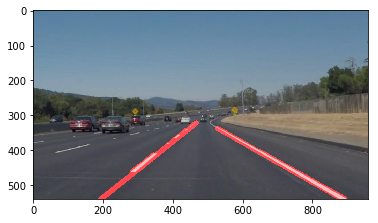

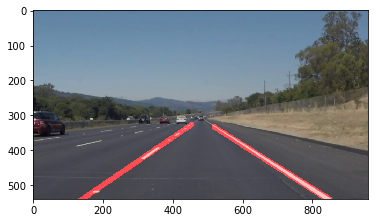

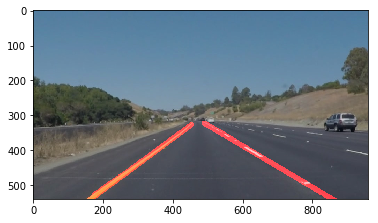

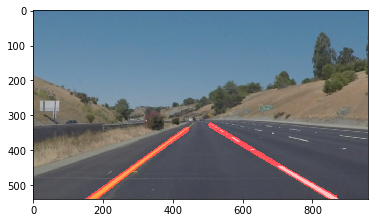

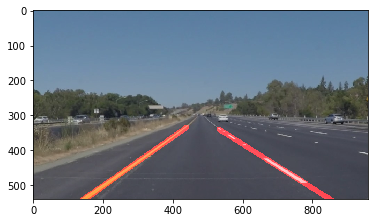

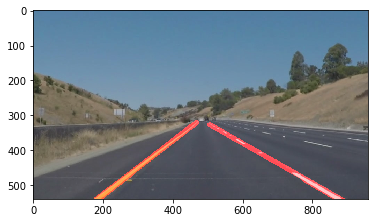

In [162]:
showImages(pipeline)

In [7]:
#edges.shape
result_img.shape

(540, 960, 3)

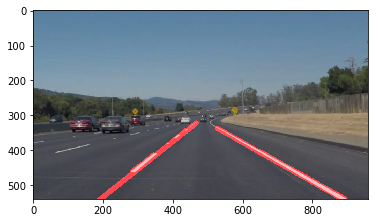

In [8]:
plt.show()
#plt.imshow(image1)
#plt.imshow(edges)
#plt.imshow(blur_img)
#plt.imshow(masked_img)
#plt.imshow(line_img)
plt.imshow(result_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [89]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
'''def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    image1 = mpimg.imread(image)
    gray = grayscale(image1)

    ###########   GAUSS_BLUR   #########
    kernel_size = 5
    blur_img = gaussian_blur(gray, kernel_size)

    ############   CANNY   ###########
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_img,low_threshold,high_threshold)

    ###########   GETTING THE REGION ######
    bottom_left = (0,edges.shape[0])
    top_left = (int((edges.shape[1]/2)-10), int((image1.shape[0]/2)+50))
    top_right = (int((edges.shape[1]/2)+10), int((image1.shape[0]/2)+50))
    bottom_right = (edges.shape[1],edges.shape[0])
    #vertices = np.array([[(0,edges.shape[0]),((edges.shape[0]/2)-10,(image1.shape[1]/2)+10),\
     #               ((image1.shape[0]/2)+10,(image1.shape[1]/2)+10),(image1.shape[0],(image1.shape[1]))]], dtype=np.int32)
    #vertices = np.array([[(0,edges.shape[0]),(450,290),(490,290),(960,540)]],dtype=np.int32)
    vertices = np.array([[(bottom_left),(top_left),(top_right),(bottom_right)]],dtype=np.int32)
    masked_img = region_of_interest(edges, vertices)

    ############   HOUGH LINES   #########
    rho = 2
    theta = np.pi/180 
    threshold = 10 
    min_line_len = 40 
    max_line_gap = 20
    line_img = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)
    result_img = weighted_img(line_img, image1, α=0.8, β=1., λ=0.)
    return result_img'''

In [30]:
'''global_values = None
def set_global_values(gv):
    global global_values
    global_values = gv

frame_index = 0
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global global_values, frame_index
    masked_img, result = lane_detection_pipeline(image, global_values)
    frame_index += 1
    return result

In [147]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    #print(type(result))
    return result

In [63]:
image1 = mpimg.imread('/Users/sarvagyagupta1/Desktop/College/SJSU/Spring_2017/udacity/1/CarND-LaneLines-P1-master/test_images/solidWhiteCurve.jpg')
result = process_image(image1)
type(result)

 Left: (468, 322) - -338 - 960
Right: (527, 337) - 1632 - 960


numpy.ndarray

In [164]:
# global_white_video_values = Global(single_img_being_processed=False, use_dominant_line_approach=False)
# set_global_values(global_white_video_values)

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)






MoviePy: building video file white.mp4
----------------------------------------

Writing video into white.mp4
|----------| 0/213   0% [elapsed: 00:00 left: ?, ? iters/sec]

/Users/sarvagyagupta1/anaconda3/anaconda/lib/python3.6/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))


Done writing video in white.mp4 !                                      
Your video is ready !
CPU times: user 4.28 s, sys: 158 ms, total: 4.44 s
Wall time: 4.45 s


In [172]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
#%time white_clip.write_videofile(white_output, audio=False)
white_clip.write_videofile(white_output, audio=False)


MoviePy: building video file white.mp4
----------------------------------------

Writing video into white.mp4
|----------| 0/213   0% [elapsed: 00:00 left: ?, ? iters/sec]

/Users/sarvagyagupta1/anaconda3/anaconda/lib/python3.6/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))


Done writing video in white.mp4 !                                      
Your video is ready !


In [12]:
print(arr)

[ 0.    0.09  0.18  0.27  0.36  0.45  0.54  0.63  0.72  0.81  0.9   0.99
  1.08  1.17  1.26  1.35  1.44  1.53  1.62  1.71  1.8   1.89  1.98  2.07
  2.16  2.25  2.34  2.43  2.52  2.61  2.7   2.79  2.88  2.97  3.06  3.15
  3.24  3.33  3.42  3.51  3.6   3.69  3.78  3.87  3.96  4.05  4.14  4.23
  4.32  4.41  4.5   4.59  4.68  4.77  4.86  4.95  5.04  5.13  5.22  5.31
  5.4   5.49  5.58  5.67  5.76  5.85  5.94  6.03  6.12  6.21  6.3   6.39
  6.48  6.57  6.66  6.75  6.84  6.93  7.02  7.11  7.2   7.29  7.38  7.47
  7.56  7.65  7.74  7.83  7.92  8.01  8.1   8.19  8.28  8.37  8.46  8.55
  8.64  8.73  8.82]


Let's try the one with the solid white lane on the right first ...

## white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
lenght = clip1.duration
arr = np.arange(0,lenght,0.09)
for t in arr:
    frame_img = clip1.get_frame(t)
    white_clip = clip1.ipub(  \   tftrsframe_img,process_image) #NOTE: this function expects color images!!
#type(clip1)
%time white_clip.write_videofile(white_output, audio=False)

In [20]:
white_output

'white.mp4'

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [173]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [167]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

# global_white_video_values = Global(single_img_being_processed=False, use_dominant_line_approach=False)
# set_global_values(global_white_video_values)

# yellow_output = 'yellow.mp4'
# clip1 = VideoFileClip("solidYellowLeft.mp4")
# yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(yellow_output, audio=False)


MoviePy: building video file yellow.mp4
----------------------------------------

Writing video into yellow.mp4
|----------| 0/654   0% [elapsed: 00:00 left: ?, ? iters/sec]

/Users/sarvagyagupta1/anaconda3/anaconda/lib/python3.6/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
/Users/sarvagyagupta1/anaconda3/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/sarvagyagupta1/anaconda3/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Done writing video in yellow.mp4 !                                     
Your video is ready !
CPU times: user 14 s, sys: 532 ms, total: 14.6 s
Wall time: 14.1 s


In [168]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [169]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


MoviePy: building video file extra.mp4
----------------------------------------

Writing video into extra.mp4
|----------| 0/241   0% [elapsed: 00:00 left: ?, ? iters/sec]

/Users/sarvagyagupta1/anaconda3/anaconda/lib/python3.6/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))


Done writing video in extra.mp4 !                                      
Your video is ready !
CPU times: user 10.1 s, sys: 1.09 s, total: 11.2 s
Wall time: 11.4 s


In [170]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))